In [1]:
import numpy as np
import seaborn
%load_ext autoreload
%autoreload 2

import copy
# import paperfig as pf
#
# pf.set_fontscale(2.)

from plot_util import *

In [2]:
savefig = False

d_index = 7
ddt_index = 3

In [3]:
# comp_weight = np.exp((bic_pl - bic_comp) / 2.)
#
comp_weight = 0

In [4]:
mc_samples_pl, *_ = get_getdist_samples('jampy', 'ifu', 'constant',
                    'axisymmetric', lens_model_type='powerlaw', snr=23,
                    oblate_fraction=0.65, blind_D=False, burnin=500, thin=5)

mc_samples_comp, *_ = get_getdist_samples('jampy', 'ifu', 'constant',
                    'axisymmetric', lens_model_type='composite', snr=23,
                    oblate_fraction=0.65, blind_D=False, burnin=500, thin=5)

mc_samples_single_slit, *_ = get_getdist_samples('jampy', 'single_slit',
                                                 'constant', 'axisymmetric',
                                                 'powerlaw', burnin=500,
                                                 shape='oblate', snr=23,
                                                 blind_D=False, thin=5
                                                 )

length = int(mc_samples_pl.samples.shape[0] * comp_weight / (1 - comp_weight))

D_d_array = np.concatenate((mc_samples_pl.samples[:, d_index],
                            mc_samples_comp.samples[:length, d_index+1]),
                           axis=0)

D_dt_array = np.concatenate((mc_samples_pl.samples[:, ddt_index],
                             mc_samples_comp.samples[:length, ddt_index+1]),
                            axis=0)

D_d_array_single_slit = mc_samples_single_slit.samples[:, d_index]
D_dt_array_single_slit = mc_samples_single_slit.samples[:, ddt_index]

print(D_d_array.shape, D_dt_array.shape)
print(D_d_array_single_slit.shape)

Removed no burn in
Removed no burn in
Removed no burn in
(32400,) (32400,)
(272592,)


In [5]:
# import 2d gaussian kde
from scipy.stats import gaussian_kde


Ddt_Dd_kde = gaussian_kde(np.vstack([D_dt_array, D_d_array]))
Ddt_kde = gaussian_kde(D_dt_array)
Dd_kde = gaussian_kde(D_d_array)

In [6]:
def log_prior_uniform(params):
    """
    """
    h0, om_m = params
    
    if not 0 < h0 < 150:
        return -np.inf
    
    if not 0.05 < om_m < .5:
        return -np.inf
    
    return 0.


def log_prior_normal(params):
    """
    """
    h0, om_m = params
    if not 0 < h0 < 150:
        return -np.inf
    
    return -0.5 * (om_m - 0.334)**2 / 0.018**2

In [7]:
from astropy.cosmology import FlatLambdaCDM

z_d = 0.295
z_s = 0.657


def log_likelihood(params):
    """
    Get the log likelihood of distances for H0 and Om_m
    """
    h0, om_m = params
    cosmo = FlatLambdaCDM(H0=h0, Om0=om_m)
    
    D_d = cosmo.angular_diameter_distance(z_d).value
    D_s = cosmo.angular_diameter_distance(z_s).value
    D_ds = cosmo.angular_diameter_distance_z1z2(z_d, z_s).value
    D_dt = (1. + z_d) * D_d * D_s / D_ds

    return np.log(Ddt_Dd_kde([D_dt, D_d]))

def log_ddt_likelihood(params):
    """
    Get the log likelihood of Ddt for H0 and Om_m
    """
    h0, om_m = params
    cosmo = FlatLambdaCDM(H0=h0, Om0=om_m)

    D_d = cosmo.angular_diameter_distance(z_d).value
    D_s = cosmo.angular_diameter_distance(z_s).value
    D_ds = cosmo.angular_diameter_distance_z1z2(z_d, z_s).value
    D_dt = (1. + z_d) * D_d * D_s / D_ds

    return np.log(Ddt_kde(D_dt))


def log_dd_likelihood(params):
    """
    Get the log likelihood of Dd for H0 and Om_m
    """
    h0, om_m = params
    cosmo = FlatLambdaCDM(H0=h0, Om0=om_m)

    D_d = cosmo.angular_diameter_distance(z_d).value

    return np.log(Dd_kde(D_d))


def log_probability(params, distance_mode='both', prior='uniform'):
    """
    :param params: (h0, om_m)
    :param distance_mode: 'both', 'ddt', 'dd'
    """
    if prior == 'uniform':
        prior = log_prior_uniform(params)
    elif prior == 'normal':
        prior = log_prior_normal(params)
    else:
        raise ValueError('prior must be either uniform or normal')
    
    if np.isinf(prior):
        return prior
    else:
        if distance_mode == 'both':
            likelihood = log_likelihood(params)
        elif distance_mode == 'ddt':
            likelihood = log_ddt_likelihood(params)
        elif distance_mode == 'dd':
            likelihood = log_dd_likelihood(params)
        else:
            raise ValueError('distance must be "both", "ddt", or "dd"')
        return likelihood + prior
    

# run emcee

In [8]:
import emcee

In [9]:
N_step = 10000

In [10]:
# uniform prior

import warnings
warnings.filterwarnings('ignore')

nwalkers, ndim = 40, 2
pos = np.array([70, 0.3]) + 1e-4 * np.random.randn(nwalkers, ndim)


sampler_uniform = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=('both', 'uniform')
)
sampler_uniform.run_mcmc(pos, N_step, progress=True);


sampler_uniform_dd_only = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=('dd', 'uniform')
)
sampler_uniform_dd_only.run_mcmc(pos, N_step, progress=True);

100%|██████████| 10000/10000 [02:31<00:00, 66.18it/s]


## normal prior

In [11]:
pos = np.array([70, 0.3]) + 1e-4 * np.random.randn(nwalkers, ndim)

warnings.filterwarnings('ignore')

sampler_normal = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=('both', 'normal')
)
sampler_normal.run_mcmc(pos, N_step, progress=True);

sampler_normal_dd_only = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=('dd', 'normal')
)
sampler_normal_dd_only.run_mcmc(pos, N_step, progress=True);

100%|██████████| 10000/10000 [02:58<00:00, 55.96it/s]


## plot

In [12]:
is_blind = False

def blind_chain(chain, mean=None):
    """
    """
    chain = copy.deepcopy(chain)
    if not is_blind:
        return chain

    # if len(chain.shape) == 1:
    #     if mean is None:
    #         mean = np.median(chain)
    #     chain -= mean
    #     chain /= mean
    # else:
    if mean is None:
        mean = np.median(chain[..., 0])
    chain[..., 0] -= mean
    chain[..., 0] /= mean

    return chain

def std(array):
    """
    """
    hi, mid, low = np.percentile(array, [84, 50, 16])

    return (hi - low) / 2.

In [13]:
chain_uniform = sampler_uniform.get_chain()
mean = np.median(chain_uniform[..., 0])
chain_uniform = blind_chain(chain_uniform, mean=mean)

chain_uniform_dd_only = sampler_uniform_dd_only.get_chain()
chain_uniform_dd_only = blind_chain(chain_uniform_dd_only, mean=mean)

In [14]:
chain_normal = sampler_normal.get_chain()
chain_normal = blind_chain(chain_normal, mean=mean)

chain_normal_dd_only = sampler_normal_dd_only.get_chain()
chain_normal_dd_only = blind_chain(chain_normal_dd_only, mean=mean)

In [15]:
thin = 10
burnin = 1000

samples_uniform = chain_uniform[burnin::thin, :, :].reshape((-1, 2))
samples_normal = chain_normal[burnin::thin, :, :].reshape((-1, 2))

samples_uniform_dd_only = chain_uniform_dd_only[burnin::thin, :, :].reshape((-1, 2))
samples_normal_dd_only = chain_normal_dd_only[burnin::thin, :, :].reshape((-1, 2))

samples_normal.shape

(36000, 2)

In [16]:
labels = ['H0', 'Om_0']

if is_blind:
    latex_labels = ['{\\rm blinded\\ } H_0', '\\Omega_{\\rm m}']
else:
    latex_labels = ['H_0\\ {(\\rm km\\ s^{-1}\\ Mpc^{-1})}', '\\Omega_{\\rm m}']

mc_samples_uniform = MCSamples(samples=samples_uniform,
                               names=labels,
                               labels=latex_labels
                              )

mc_samples_normal = MCSamples(samples=samples_normal,
                              names=labels,
                              labels=latex_labels
                             )

mc_samples_uniform_dd_only = MCSamples(samples=samples_uniform_dd_only,
                               names=labels,
                               labels=latex_labels
                              )

mc_samples_normal_dd_only = MCSamples(samples=samples_normal_dd_only,
                                names=labels,
                                labels=latex_labels
                            )

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


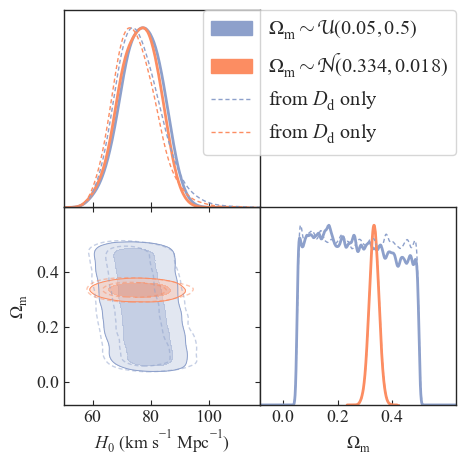

In [17]:
pf.set_fontscale(2.)

font_scale = .92

g = plots.getSubplotPlotter(subplot_size=2.5)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5

g.settings.axes_fontsize = 16 * font_scale
g.settings.lab_fontsize = 16 * font_scale

g.settings.legend_fontsize = 18 * font_scale

colors = [pf.cb2_blue, pf.cb2_orange, pf.cb2_blue, pf.cb2_orange]

legend_labels = [r'$\Omega_{\rm m} \sim \mathcal{U}(0.05, 0.5)$', 
                 r'$\Omega_{\rm m} \sim \mathcal{N}(0.334, 0.018)$',
                 r'from $D_{\rm d}$ only',
                 r'from $D_{\rm d}$ only',
                 ]

g.triangle_plot([mc_samples_uniform,
                 mc_samples_normal,
                 mc_samples_uniform_dd_only,
                 mc_samples_normal_dd_only,
                 ],
                legend_labels=legend_labels,
                #filled=True,
                shaded=False,
                alpha_filled_add=.5,
                contour_lws=[2, 2, 1, 1],
                contour_ls=['-', '-', '--', '--'],
                filled=[True, True, False, False],
                # contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']],
                contour_args={'alpha': .5},
                # line_args={'lw': 7., "zorder": 30},
                # line_args={'lw': 1., 'alpha': 1.}
                contour_colors=colors,
                #                     param_limits={'dphi_AB': (-0.45, 0.15),
                #                                   'dphi_AC': (-0.45, 0.15),
                #                                   'dphi_AD': (-0.45, 0.15),
                #                                   'lambda_int': (0.3, 3), 'a_ani': (0.5, 5.)},
                )

# g.settings.smooth_scale_2D = 4
# g.settings.smooth_scale_1D = 4

if savefig:
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/H0_plot.pdf',
                  bbox_inches='tight'
                 )

In [18]:
def print_median_percentiles(arr):
    """
    Print
    """
    hi, mid, low = np.percentile(arr, [84, 50, 16])
    print(r'{:.1f}_{{-{:.1f}}}^{{+{:.1f}}}'.format(mid, mid - low, hi - mid))
    print('percentage: {:.1f}%'.format((hi - low) / 2 / mid * 100))

def print_median_percentiles_distances(arr):
    """
    Print
    """
    hi, mid, low = np.percentile(arr, [84, 50, 16])
    print(r'{:.0f}_{{-{:.0f}}}^{{+{:.0f}}}'.format(mid, mid - low, hi - mid))
    print('percentage: {:.1f}%'.format((hi - low) / 2 / mid * 100))

In [19]:
print('Medians: uniform: {:.3f}, normal: {:.3f}'.format(
    np.median(samples_uniform[:, 0]),
    np.median(samples_normal[:,0])))

print_median_percentiles(samples_uniform[:, 0])

print_median_percentiles(samples_normal[:, 0])

Medians: uniform: 77.103, normal: 76.230
77.1_{-7.2}^{+7.1}
percentage: 9.3%
76.2_{-7.2}^{+6.9}
percentage: 9.2%


In [20]:
print('deviations: uniform: {:.3f}, normal: {:.3f}'.format(
    std(samples_uniform[:, 0]), std(samples_normal[:, 0])
))

deviations: uniform: 7.160, normal: 7.037


In [21]:
print('Medians from D_d only')
print('Medians: uniform: {:.3f}, normal: {:.3f}'.format(
    np.median(samples_uniform_dd_only[:, 0]),
    np.median(samples_normal_dd_only[:, 0])
))

print_median_percentiles(samples_uniform_dd_only[:, 0])

Medians from D_d only
Medians: uniform: 75.375, normal: 74.293
75.4_{-7.0}^{+8.4}
percentage: 10.2%


In [22]:
print('STDs from D_d only')
print('deviations: uniform: {:.2f}, normal: {:.2f}'.format(
    std(samples_uniform_dd_only[:, 0]), std(samples_normal_dd_only[:, 0])
))

print_median_percentiles(samples_normal_dd_only[:, 0])

STDs from D_d only
deviations: uniform: 7.71, normal: 7.29
74.3_{-6.8}^{+7.8}
percentage: 9.8%


In [23]:
(np.median(samples_uniform_dd_only[:, 0] - samples_uniform[:, 0]) / np.median(samples_uniform[:, 0]) * 100)

-1.554731457039177

In [24]:
np.median(samples_normal_dd_only[:, 0] - samples_normal[:, 0]) / np.median(samples_normal[:, 0]) * 100

-1.9607122908120815

In [25]:
print_median_percentiles_distances(D_dt_array)

print_median_percentiles_distances(D_d_array)

2171_{-266}^{+478}
percentage: 17.1%
866_{-81}^{+84}
percentage: 9.5%


In [26]:
20 / 323

0.06191950464396285

In [27]:
(323 - 287) / 323

0.11145510835913312

## Distance plot

Removed no burn in
Removed no burn in


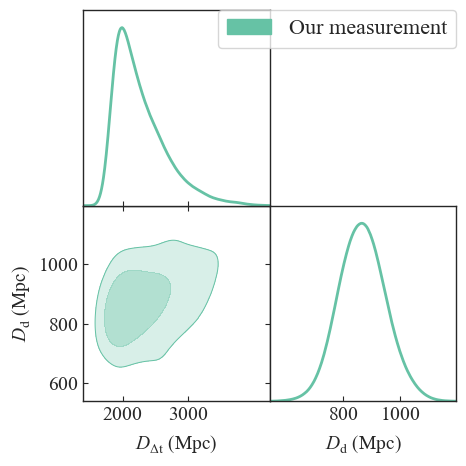

In [28]:
font_scale = 1

mc_samples_distances = MCSamples(samples=[D_dt_array,
                                          D_d_array],
                                 names=['D_dt', 'D_d'],
                                 labels=['D_{\\rm \\Delta t}\\ {\\rm (Mpc)}',
                                         'D_{\\rm d}\\ {\\rm (Mpc)}']
                                )

mc_samples_distances_single_slit = MCSamples(samples=[D_dt_array_single_slit,
                                          D_d_array_single_slit],
                                 names=['D_dt', 'D_d'],
                                 labels=['D_{\\rm \\Delta t}\\ {\\rm (Mpc)}',
                                         'D_{\\rm d}\\ {\\rm (Mpc)}']
                                )


g_d = plots.getSubplotPlotter(subplot_size=2.5)
g_d.settings.lw_contour = 1.
g_d.settings.alpha_factor_contour_lines = 2.
g_d.settings.solid_contour_palefactor = 0.5

g_d.settings.axes_fontsize = 16 * font_scale
g_d.settings.lab_fontsize = 16 * font_scale

g_d.settings.legend_fontsize = 18 * font_scale

colors = [pf.cb2_blue, pf.cb2_orange, pf.cb2_emerald, pf.cb_grey]

legend_labels = ['Our measurement']

g_d.triangle_plot([mc_samples_distances,
                   #mc_samples_distances_single_slit
                   ],
                legend_labels=legend_labels,
                filled=True, shaded=False,
                alpha_filled_add=.5,
                contour_lws=[2 for l in legend_labels],
                contour_ls=['-' for l in legend_labels],
                # filled=False,
                # contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']],
                contour_args={'alpha': .5},
                # line_args={'lw': 7., "zorder": 30},
                # line_args={'lw': 1., 'alpha': 1.}
                contour_colors=colors[2:],
                #                     param_limits={'dphi_AB': (-0.45, 0.15),
                #                                   'dphi_AC': (-0.45, 0.15),
                #                                   'dphi_AD': (-0.45, 0.15),
                #                                   'lambda_int': (0.3, 3), 'a_ani': (0.5, 5.)},
                )

if is_blind:
    axes = g_d.fig.get_axes()
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])


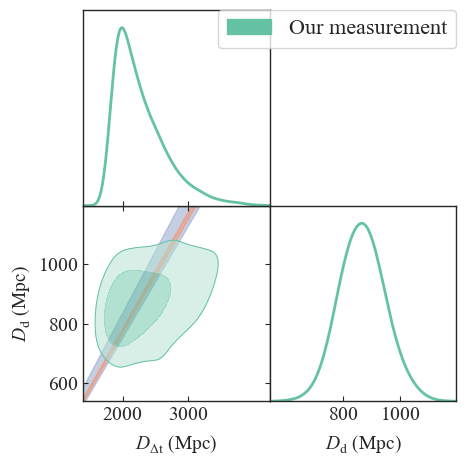

In [29]:
from scipy.interpolate import interp1d


ax_2d = g_d.fig.get_axes()[0]

h0s = np.linspace(0, 150, 1000)

def get_distances(om_m):
    cosmo = FlatLambdaCDM(H0=70, Om0=om_m)
    D_d = cosmo.angular_diameter_distance(z_d).value
    D_s = cosmo.angular_diameter_distance(z_s).value
    D_ds = cosmo.angular_diameter_distance_z1z2(z_d, z_s).value
    D_dt = (1 + z_d) * D_d * D_s / D_ds
    return D_dt * 70 / h0s, D_d * 70 / h0s

D_dt_vals = np.linspace(1000, 5000, 1000)


D_dt, D_d = get_distances(0.05)
D_d_interp_1 = interp1d(D_dt, D_d, bounds_error=False, fill_value=0)

D_dt, D_d = get_distances(0.5)
D_d_interp_2 = interp1d(D_dt, D_d, bounds_error=False, fill_value=0)
ax_2d.fill_between(D_dt_vals, D_d_interp_1(D_dt_vals),
                   D_d_interp_2(D_dt_vals),
                   color=pf.cb2_blue,
                   alpha=0.5, zorder=-20,
                   label=r'$\Omega_{\rm m} \sim \mathcal{U}(0.05, 0.5)$'
                   )

D_dt, D_d = get_distances(0.334-3*0.018)
D_d_interp_1 = interp1d(D_dt, D_d, bounds_error=False, fill_value=0)

D_dt, D_d = get_distances(0.334+3*0.018)
D_d_interp_2 = interp1d(D_dt, D_d, bounds_error=False, fill_value=0)
ax_2d.fill_between(D_dt_vals, D_d_interp_1(D_dt_vals),
                   D_d_interp_2(D_dt_vals),
                   color=pf.cb2_orange,
                   alpha=0.5, zorder=-10,
                   label=r'$\Omega_{\rm m} \sim \mathcal{N}(0.334, 0.018)$')

# # update figure legend
# handles, labels = ax_2d.get_legend_handles_labels()
# ax_1 = g.fig.get_axes()[1]
#
# handles_2, labels_2 = ax_1.get_legend_handles_labels()
# handles += handles_2
# labels += labels_2
# ax_1.legend(handles, labels, loc='upper left',
#             fontsize=16 * font_scale)
if savefig:
    g_d.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi'
                  '/figures/2d_distance_plot.pdf',
                  bbox_inches='tight'
                 )

g_d.fig

## Comparison plot with previous H_0 measurements

In [30]:
chen_19_h0_scrapped_points = [
    65.98032786885246, 0.003956478733927238,
    67.42295081967212, 0.009891196834817206,
    68.70819672131148, 0.017804154302670128,
    69.9672131147541, 0.03066271018793265,
    70.91147540983607, 0.04846686449060322,
    71.80327868852459, 0.07715133531157248,
    72.64262295081967, 0.10682492581602343,
    73.21967213114755, 0.13353115727002962,
    73.82295081967213, 0.17210682492581597,
    74.34754098360656, 0.21859545004945602,
    74.84590163934426, 0.26805143422354105,
    75.29180327868852, 0.3194856577645896,
    75.76393442622951, 0.3689416419386745,
    76.2360655737705, 0.42037586547972294,
    76.81311475409836, 0.4747774480712166,
    77.31147540983606, 0.5133531157270029,
    77.78360655737706, 0.5430267062314541,
    78.72786885245903, 0.5281899109792286,
    79.30491803278689, 0.5113748763600399,
    79.64590163934426, 0.48170128585558847,
    80.32786885245902, 0.42037586547972294,
    81.00983606557377, 0.35509396636993074,
    81.79672131147542, 0.27992087042532154,
    82.42622950819673, 0.2235410484668645,
    83.26557377049181, 0.1681503461918893,
    84.18360655737706, 0.11572700296735916,
    85.52131147540982, 0.05242334322453024,
    86.62295081967214, 0.02571711177052416,
    87.77704918032785, 0.005934718100890635,
    89.82295081967214, 0.0009891196834816984,
]

In [31]:
def plot_with_1sig_error(h0_array, ax, height, **kwargs):
    """
    Plot the H_0 measurements with 1 sigma error bars
    """
    kde_1d = gaussian_kde(h0_array)

    h0s = np.linspace(50, 110, 1000)

    dist = kde_1d(h0s)
    ax.plot(h0s, dist, **kwargs)

    low, mid, high = np.percentile(h0_array, q=[16, 50, 84])

    ax.plot(mid, height, 'o', color=kwargs['color'], ms=10)
    ax.plot([low, high],
            [height, height],
            color=kwargs['color'], ls='-', lw=kwargs['lw'])
    # if 'alpha' in kwargs:
    #     alpha = kwargs['alpha']
    # else:
    #     alpha = 1
    # ax.fill_between(h0s, dist, where=(h0s > low) & (h0s < high),
    #                 color=kwargs['color'], alpha=alpha*0.25)

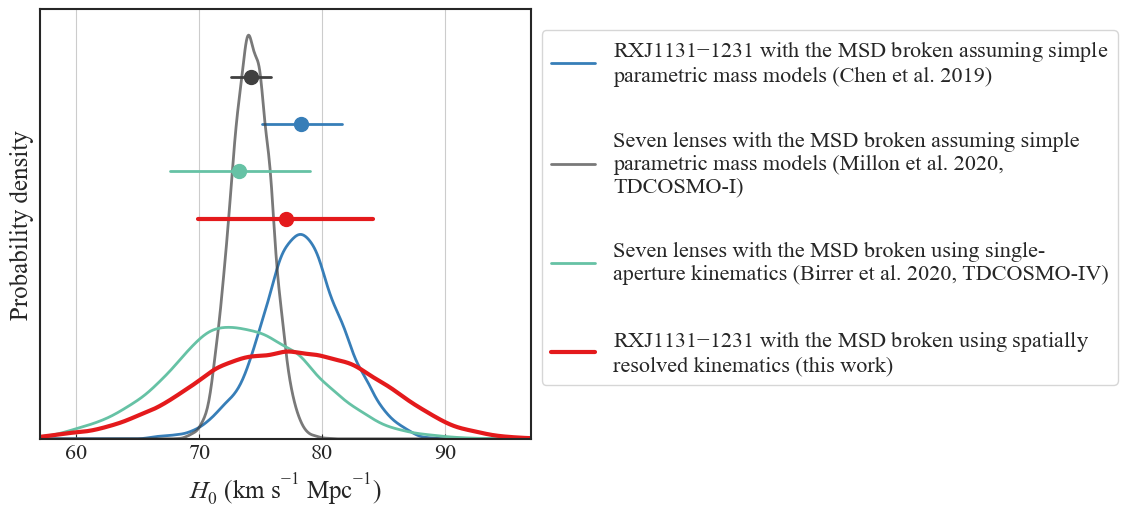

In [33]:
from textwrap import wrap

pf.set_fontscale(2)

chen_19_h0_interp = interp1d(
    chen_19_h0_scrapped_points[::2],
    chen_19_h0_scrapped_points[1::2],
    bounds_error=False,
    fill_value=0
)

vals = np.random.uniform(65, 90, 100000)
weights = chen_19_h0_interp(vals)
weights = weights / np.sum(weights)

chen_19_h0 = np.random.choice(vals, p=weights, size=10000)
millon_20_h0 = np.random.normal(74.2, 1.6, 10000)
birrer_20_h0 = np.random.normal(73.3, 5.8, 10000)

fig, axes = plt.subplots(1, 2, figsize=pf.get_fig_size(
                                               width=pf.mnras_textwidth*2,
                                               height_ratio=0.4))
ax = axes[0]

labels = [
    r'RXJ1131$-$1231 with the MSD broken assuming simple parametric mass '
    r'models (Chen et al. 2019)',
    r'Seven lenses with the MSD broken assuming simple parametric mass models '
    r'(Millon et al. 2020, TDCOSMO-I)',
    r'Seven lenses with the MSD broken using single-aperture kinematics '
    r'(Birrer et al. 2020, TDCOSMO-IV)',
    r'RXJ1131$-$1231 with the MSD broken using spatially resolved kinematics '
    r'(this work)',
]

lw = 2
# sns.kdeplot(chen_19_h0, label=labels[0], color=pf.cb_blue, ax=ax, lw=lw)
# sns.kdeplot(millon_20_h0, label=labels[1], color=pf.cb_grey, ax=ax, lw=lw,
#             alpha=0.7)
# sns.kdeplot(birrer_20_h0, label=labels[2], color=pf.cb2_emerald, ax=ax, lw=lw)

heights = np.array([0.22, 0.25, 0.19, 0.16]) - 0.02
heights /= 1.05

plot_with_1sig_error(chen_19_h0, ax, height=heights[0],
                     label=labels[0],
                     color=pf.cb_blue, lw=lw)
plot_with_1sig_error(millon_20_h0, ax, height=heights[1],
                     label=labels[1],
                     color=pf.cb_grey, lw=lw, alpha=0.7)
plot_with_1sig_error(birrer_20_h0, ax, height=heights[2],
                     label=labels[2],
                     color=pf.cb2_emerald, lw=lw)

if is_blind:
    # sns.kdeplot(samples_uniform[:, 0]*70 + 70, label=labels[3],
    #             color=pf.cb_red,
    #             lw=6, ax=ax)
    plot_with_1sig_error(samples_uniform[:, 0]*70 + 70,
                         ax, height=heights[3],
                         label=labels[3],
                         color=pf.cb_red,
                         lw=lw*1.5)
else:
    plot_with_1sig_error(samples_uniform[:, 0],
                         ax, height=heights[3],
                         label=labels[3],
                         color=pf.cb_red,
                         lw=lw*1.5)


ax.set_xlim(57, 97)
ax.set_xlabel(r'$H_0$ (km s$^{-1}$ Mpc$^{-1}$)')

handles, labels = ax.get_legend_handles_labels()
labels = ['\n'.join(wrap(l, 53)) for l in labels]
ax.legend(handles, labels, bbox_to_anchor=(1, 0.1),
          labelspacing=2
          ) #, fontsize=18)

ax.set_yticks([])
ax.set_ylim(0, 0.26)
ax.set_ylabel('Probability density')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

axes[1].axis('off')

ax.grid(True)

# fig.tight_layout()

if True:
    fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi'
                '/figures/h0_comparison.pdf',
                bbox_inches='tight'
               )


## compare single slit vs IFU

In [67]:
Ddt_Dd_kde_single_slit = gaussian_kde(np.vstack([D_dt_array_single_slit,
                                               D_d_array_single_slit]))

def log_likelihood_single_slit(params):
    """
    Get the log likelihood of distances for H0 and Om_m
    """
    h0, om_m = params
    cosmo = FlatLambdaCDM(H0=h0, Om0=om_m)

    D_d = cosmo.angular_diameter_distance(z_d).value
    D_s = cosmo.angular_diameter_distance(z_s).value
    D_ds = cosmo.angular_diameter_distance_z1z2(z_d, z_s).value
    D_dt = (1. + z_d) * D_d * D_s / D_ds

    return np.log(Ddt_Dd_kde_single_slit([D_dt, D_d]))

def log_probability_single_slit(params):
    """
    Get the log probability of distances for H0 and Om_m
    """
    h0, om_m = params
    if 0 < h0 < 150 and 0.05 < om_m < 0.5:
        return log_likelihood_single_slit(params)
    return -np.inf

In [68]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    nwalkers, ndim = 40, 2
    pos_single_slit = np.array([70, 0.3]) + 1e-4 * np.random.randn(nwalkers,
                                                                   ndim)

    sampler_single_slit = emcee.EnsembleSampler(nwalkers, ndim,
                                                log_probability_single_slit)
    sampler_single_slit.run_mcmc(pos_single_slit, N_step, progress=True);

100%|██████████| 2000/2000 [04:45<00:00,  7.01it/s]


In [93]:
chain_single_slit_uniform = sampler_single_slit.get_chain()
# chain_single_slit_uniform = blind_chain(chain_single_slit_uniform, mean=mean)

In [94]:
samples_single_slit_uniform = chain_single_slit_uniform[burnin::thin, :, :].reshape((-1, 2))

In [95]:
std(samples_single_slit_uniform[:, 0]) / np.mean(samples_single_slit_uniform[:, 0])

0.12527415412195445

In [96]:
print_median_percentiles_distances(D_d_array_single_slit)

889_{-130}^{+149}
percentage: 15.7%


In [97]:
print_median_percentiles(samples_single_slit_uniform[:, 0])

76.0_{-10.0}^{+8.9}
percentage: 12.5%
